# Core 2 - Explaining Models with SHAP

- Name: Tyler Schelling
- Date: 1/26/2023

## Task

- For this assignment, you will continue revisiting your first project to predict supermarket sales. You will be applying everything you've learned thus far this week to explain how your models made their predictions.

## Part 1: Load Your Saved Joblib File

- Create a new notebook for this assignment in your project 1 repository. Name the notebook "Explaining Models with Shap.ipynb"
- In your notebook, load the contents of your "best-models.joblib" file into a variable called "loaded_joblib."
- Save each object from the loaded_joblib dictionary as a separate variable in your notebook. (e.g. "X_train = loaded_joblib['X_train'])

### Import Libraries

In [23]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss
import joblib, os

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import shap
shap.initjs()
from lime.lime_tabular import LimeTabularExplainer


## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

### Define Functions

In [2]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

### Load the Model

In [3]:
fname = "Models/Core1-linreg-RF.joblib"
loaded_joblib = joblib.load(fname)

loaded_joblib.keys()

dict_keys(['preprocessor', 'X_train', 'X_test', 'y_train', 'y_test', 'LinearRegression', 'RandomForest'])

In [4]:
## Saving the loaded objects as separate varaibles
X_train = loaded_joblib['X_train']
y_train = loaded_joblib['y_train']
X_test = loaded_joblib['X_test']
y_test = loaded_joblib['y_test']

preprocessor = loaded_joblib['preprocessor']
lin_reg = loaded_joblib['LinearRegression']
rf_reg = loaded_joblib['RandomForest']
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001B56F699A30>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001B56F699E50>)],
                  verbose_feature_names_out=False)

## Part 2: Explain Your Tree-Based Model with SHAP

- Create an X_shap and y_shap variable from your training data (use shap.sample as needed).
- Create a model explainer,
- Calculate the shap values for your model.
- Create a summary plot - with plot_type='bar':
    - In a Markdown cell below, display your saved feature importance image (that you used in your README) and compare the most important features according to SHAP vs. your original feature importances.
        - Are they the same features in both? If not, what's different?
    - Save your bar summary plot figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README).
- Create a second summary plot - with plot_type='dot'
    - In a markdown cell, interpret the top 3 most important features and how they influence your model's predictions.
    - Save your figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README).

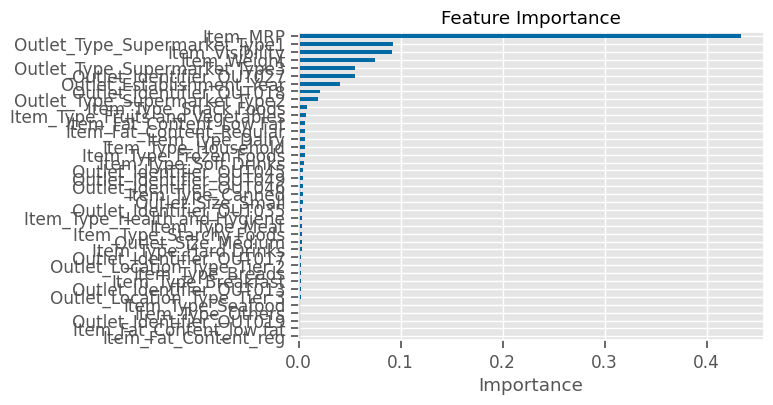

In [5]:
## evaluate the random forest
evaluate_regression(rf_reg,X_train,y_train, X_test, y_test)

## extract the plot the feature importances
importances = get_importances(rf_reg)
plot_importances(importances);

### Model Explainer

In [6]:
X_shap = shap.sample(X_train, nsamples = 500, random_state=SEED)
X_shap

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
3888     0.628362         0.873252 -1.677139                   1.089517   
2497     0.466190         0.418566  1.275305                  -0.102145   
7723     0.985140        -0.986085  0.684178                   0.493686   
8117    -0.463597        -0.316610  1.616527                   0.493686   
7475     0.444567        -0.410893 -0.023898                   0.493686   
...           ...              ...       ...                        ...   
3467    -0.679826         1.474760 -1.468751                   1.089517   
2322     1.277050         1.379431  0.282277                  -1.532139   
3435     1.460845        -0.973438  0.710190                   0.493686   
6561    -0.074384        -0.670765  0.488564                   1.089517   
7431    -0.398728        -1.083918 -0.914813                  -1.532139   

      Item_Fat_Content_Low Fat  Item_Fat_Content_Regular  \
3888                       0.0                       1.0   
2497                       0.0                       1.0   
7723                       1.0                       0.0   
8117                       1.0                       0.0   
7475                       1.0                       0.0   
...                        ...                       ...   
3467                       0.0                       1.0   
2322                       1.0                       0.0   
3435                       0.0                       1.0   
6561                       0.0                       1.0   
7431                       1.0                       0.0   

      Item_Fat_Content_low fat  Item_Fat_Content_reg  Item_Type_Breads  \
3888                       0.0                   0.0               0.0   
2497                       0.0                   0.0               0.0   
7723                       0.0                   0.0               0.0   
8117                       0.0                   0.0               0.0   
7475                       0.0                   0.0               0.0   
...                        ...                   ...               ...   
3467                       0.0                   0.0               0.0   
2322                       0.0                   0.0               0.0   
3435                       0.0                   0.0               0.0   
6561                       0.0                   0.0               0.0   
7431                       0.0                   0.0               0.0   

      Item_Type_Breakfast  ...  Outlet_Identifier_OUT045  \
3888                  0.0  ...                       0.0   
2497                  0.0  ...                       0.0   
7723                  0.0  ...                       1.0   
8117                  0.0  ...                       1.0   
7475                  0.0  ...                       1.0   
...                   ...  ...                       ...   
3467                  0.0  ...                       0.0   
2322                  0.0  ...                       0.0   
3435                  0.0  ...                       1.0   
6561                  0.0  ...                       0.0   
7431                  0.0  ...                       0.0   

      Outlet_Identifier_OUT046  Outlet_Identifier_OUT049  Outlet_Size_Medium  \
3888                       0.0                       0.0                 1.0   
2497                       1.0                       0.0                 0.0   
7723                       0.0                       0.0                 1.0   
8117                       0.0                       0.0                 1.0   
7475                       0.0                       0.0                 1.0   
...                        ...                       ...                 ...   
3467                       0.0                       0.0                 1.0   
2322                       0.0                       0.0                 1.0   
3435                       0.0                       0

In [7]:
y_shap = y_train.loc[X_shap.index]
y_shap

3888     759.0120
2497     663.1368
7723    2766.3990
8117    1225.0720
7475    1685.8056
          ...    
3467     506.0080
2322    2888.2404
3435    5069.4012
6561    1030.6584
7431    3691.1952
Name: Item_Outlet_Sales, Length: 500, dtype: float64

In [8]:
explainer = shap.Explainer(rf_reg)
explainer

In [9]:
## Get shap values from the explainer
shap_values = explainer(X_shap, y_shap)

In [10]:
shap_values[0]

.values =
array([ 3.10152669e+00, -5.70976358e+00, -1.68554799e+03,  3.91600798e+01,
        2.89716567e+00,  2.58255196e+00, -5.91679507e-01, -3.51107512e-01,
       -9.66177392e-02, -8.57650931e-01, -4.04797675e-01,  1.28565264e+00,
        1.63421963e+01, -2.87145550e+00, -1.62907677e+00, -6.07262141e+00,
        1.72940948e-01, -4.97665511e-01, -2.49936470e-01, -1.02644010e+00,
       -1.91080100e+00, -2.22813440e+00, -8.71383227e-03, -7.12668960e-01,
        8.53560128e+00, -2.32452727e+01,  1.64409183e+00, -5.26665736e+01,
       -2.23010249e+00,  6.16370262e+00,  1.19671468e+00, -2.48525080e+00,
        1.13125098e+00,  3.66700240e+00, -1.45247074e-01, -3.27889628e-01,
        2.04391332e+02, -2.18714894e+01, -5.06804851e+01])

.base_values =
array([2211.93481346])

.data =
array([ 0.62836185,  0.87325195, -1.67713926,  1.0895166 ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.  

In [11]:
shap_values.shape

(500, 39)

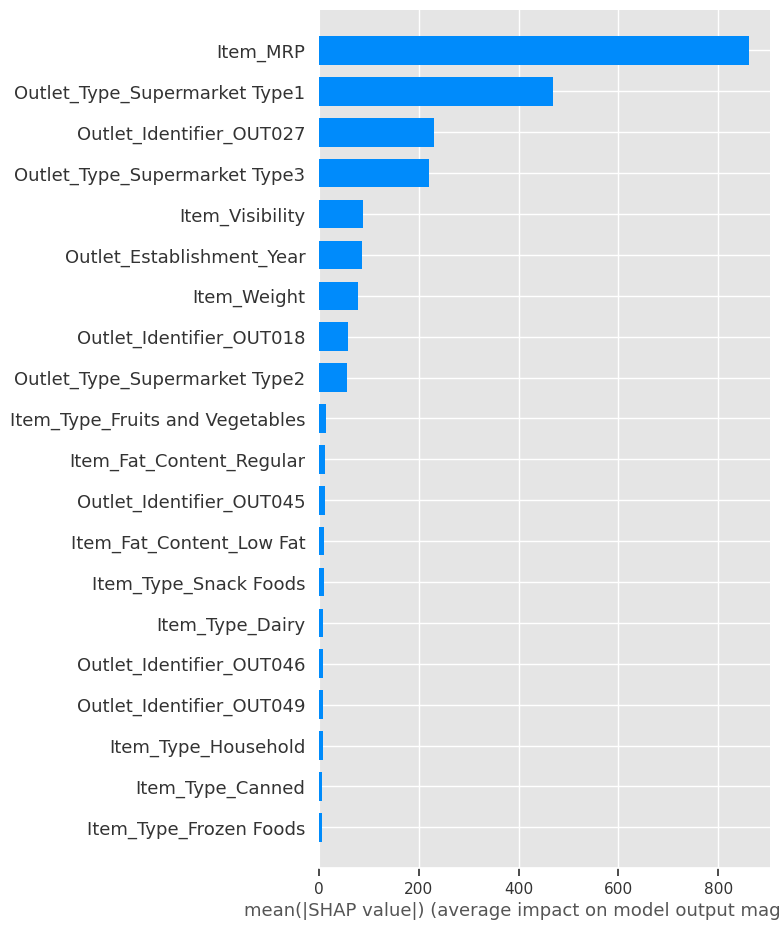

In [12]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values, features=X_shap, plot_type='bar')
ax.set_title('Summary Plot - Bar')
fig.savefig('images/summary_plot_bar')

- The top 2 results that SHAP had are the same important features compared to the original feature importances.
    - Item_MRP and Outlet_Type_Supermarket Type1 are the top 2 in both outputs.
- Beyond the first two, the outputs differ.
    - 3rd Original was Item_visibility compared to SHAP's Outlet_Identifier_OUT027.
    - 4th Original was Item_weight compared to SHAP's Outlet_Type_Supermarket Type3.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


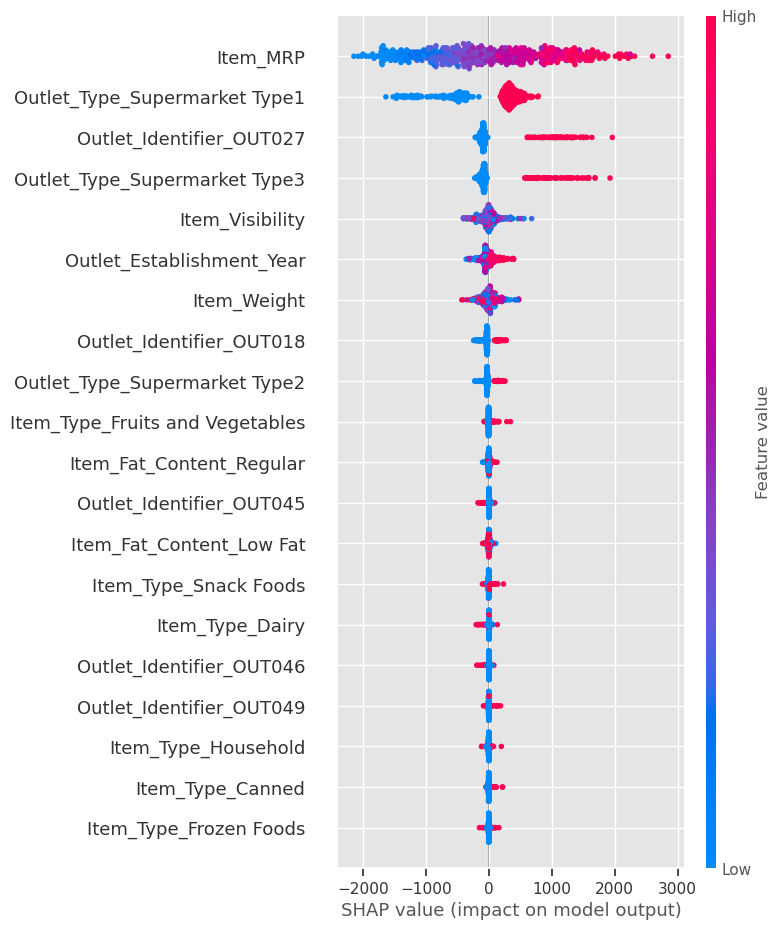

In [13]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values, features=X_shap, plot_type='dot')
ax.set_title('Summary Plot - Dot')
fig.savefig('images/summary_plot_dot');

- The Item_MRP has the largest spread of valus which has a significant impact on the outlet sales. 
    - Higher priced items have a positive impact on the sales performance.
    - Lower priced items have a negative impact on the sales performance.
    
- Outlet_Type_Supermarket Type1 has an interesting spread. 
    - Would require further analysis into the different outlet_sizes that make up the Supermarket Type1 category as that may have an influence on the spread of impact to sales performance.
    - Higher values (assumed larger outlet_sizes) for the Supermarket Type1 have a positive impact on the sales performance.
    
- Outlet_Identifier_OUT027 shows that this specific store performs better across all other stores and has a positive impact on sales performance.

## Part 3: Update your README

- Insert your exported figures and corresponding interpretations from above into your README file. You should have:
    - a summary plot - bar version
        - Your comparison of most important features found by shap vs feature importance.
    - a summary plot - dot version
        - Your interpretation of the top 3 most important features and how they influence your model's predictions.

# Core 3 - Local Explanations

- Name: Tyler Schelling
- Date: 1/27/2023

## Task

- For this assignment, you will be revisiting your first project to predict supermarket sales. You will be applying everything you've learned this week to explain how your models made their predictions.

## Part 1: Local Explanations

Continue working in your model explanation notebook from the previous core assignment. Add a new "Local Explanations" header at the bottom and continue your work:

- Select at least 2 example rows/outlets based on the insights gained from your previous core assignments this week.

- Explain why you selected the examples that you did.
    - If you're having trouble thinking of which type of examples to select, try selecting a store that had low sales ( one of the lowest values for your target) and one with high sales (the highest values for your target).
- For each example, produce :
    - a Lime tabular explanation
        - Interpret what features most heavily influenced the predictions, according to LIME.
        - Save your figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README). Note: you will need to take a screenshot to save the lime explanation.
    - an Individual Force Plot
        - Interpret what features most heavily influenced the predictions, according to SHAP.
        - Save your figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README). Note: you will need to take a screenshot to save the individual force plot.

### Lowest Item_MRP Row

In [14]:
X_shap

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
3888     0.628362         0.873252 -1.677139                   1.089517   
2497     0.466190         0.418566  1.275305                  -0.102145   
7723     0.985140        -0.986085  0.684178                   0.493686   
8117    -0.463597        -0.316610  1.616527                   0.493686   
7475     0.444567        -0.410893 -0.023898                   0.493686   
...           ...              ...       ...                        ...   
3467    -0.679826         1.474760 -1.468751                   1.089517   
2322     1.277050         1.379431  0.282277                  -1.532139   
3435     1.460845        -0.973438  0.710190                   0.493686   
6561    -0.074384        -0.670765  0.488564                   1.089517   
7431    -0.398728        -1.083918 -0.914813                  -1.532139   

      Item_Fat_Content_Low Fat  Item_Fat_Content_Regular  \
3888                       0.0                       1.0   
2497                       0.0                       1.0   
7723                       1.0                       0.0   
8117                       1.0                       0.0   
7475                       1.0                       0.0   
...                        ...                       ...   
3467                       0.0                       1.0   
2322                       1.0                       0.0   
3435                       0.0                       1.0   
6561                       0.0                       1.0   
7431                       1.0                       0.0   

      Item_Fat_Content_low fat  Item_Fat_Content_reg  Item_Type_Breads  \
3888                       0.0                   0.0               0.0   
2497                       0.0                   0.0               0.0   
7723                       0.0                   0.0               0.0   
8117                       0.0                   0.0               0.0   
7475                       0.0                   0.0               0.0   
...                        ...                   ...               ...   
3467                       0.0                   0.0               0.0   
2322                       0.0                   0.0               0.0   
3435                       0.0                   0.0               0.0   
6561                       0.0                   0.0               0.0   
7431                       0.0                   0.0               0.0   

      Item_Type_Breakfast  ...  Outlet_Identifier_OUT045  \
3888                  0.0  ...                       0.0   
2497                  0.0  ...                       0.0   
7723                  0.0  ...                       1.0   
8117                  0.0  ...                       1.0   
7475                  0.0  ...                       1.0   
...                   ...  ...                       ...   
3467                  0.0  ...                       0.0   
2322                  0.0  ...                       0.0   
3435                  0.0  ...                       1.0   
6561                  0.0  ...                       0.0   
7431                  0.0  ...                       0.0   

      Outlet_Identifier_OUT046  Outlet_Identifier_OUT049  Outlet_Size_Medium  \
3888                       0.0                       0.0                 1.0   
2497                       1.0                       0.0                 0.0   
7723                       0.0                       0.0                 1.0   
8117                       0.0                       0.0                 1.0   
7475                       0.0                       0.0                 1.0   
...                        ...                       ...                 ...   
3467                       0.0                       0.0                 1.0   
2322                       0.0                       0.0                 1.0   
3435                       0.0                       0

In [15]:
X_shap_local = X_shap.reset_index(drop = True)
y_shap_local = y_shap.reset_index(drop = True)

In [16]:
idx_lowcost = X_shap_local['Item_MRP'].idxmin()
idx_lowcost

6

In [17]:
X_shap_local.iloc[idx_lowcost]

Item_Weight                        0.682419
Item_Visibility                    1.832535
Item_MRP                          -1.755301
Outlet_Establishment_Year          0.732018
Item_Fat_Content_Low Fat           0.000000
Item_Fat_Content_Regular           1.000000
Item_Fat_Content_low fat           0.000000
Item_Fat_Content_reg               0.000000
Item_Type_Breads                   0.000000
Item_Type_Breakfast                0.000000
Item_Type_Canned                   0.000000
Item_Type_Dairy                    0.000000
Item_Type_Frozen Foods             1.000000
Item_Type_Fruits and Vegetables    0.000000
Item_Type_Hard Drinks              0.000000
Item_Type_Health and Hygiene       0.000000
Item_Type_Household                0.000000
Item_Type_Meat                     0.000000
Item_Type_Others                   0.000000
Item_Type_Seafood                  0.000000
Item_Type_Snack Foods              0.000000
Item_Type_Soft Drinks              0.000000
Item_Type_Starchy Foods         

In [18]:
y_shap_local.iloc[idx_lowcost]

1018.674

In [19]:
shap_values[idx_lowcost]

.values =
array([ 2.26617931e+01,  5.12705972e+01, -1.69519380e+03,  4.34321828e+01,
        2.29323798e-01,  7.61712357e+00, -2.87199426e-01,  1.51612473e-01,
       -1.26405657e+00, -9.93271687e-01, -1.35363335e+00,  1.29659860e+00,
        1.11949279e+01, -2.22645324e+00, -8.28221458e-01, -1.60863085e+00,
        2.58993825e+00, -3.10004615e-01, -2.02659011e-01, -1.47223119e+00,
       -7.17235827e-01, -2.52106069e-01, -1.21037651e+00, -5.30069994e-01,
       -1.04212593e+00, -2.27937468e+01,  1.70581837e+00, -5.52486277e+01,
        3.11718811e+01,  3.45616024e+00,  6.95543513e+00, -1.24832100e+00,
        6.40204903e+00,  1.42834211e+01,  2.30447286e+00, -7.12207754e-02,
        2.15362213e+02, -2.13180715e+01, -5.17067231e+01])

.base_values =
array([2211.93481346])

.data =
array([ 0.6824192 ,  1.83253491, -1.75530051,  0.73201809,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.  

In [22]:
shap.force_plot(explainer.expected_value, 
               shap_values[idx_lowcost].values,
               features = X_shap_local.iloc[idx_lowcost])

- Item_MRP had the largest overall impact to the final sales performance in the negative direction.
- Outlet_Type_Supermarket Type1 had a minor positive impact.

In [25]:
## Create a lime explainer with X_shap_local with regression as the mode
lime_explainer = LimeTabularExplainer(training_data = X_shap_local.values,
                                     feature_names=X_shap_local.columns, 
                                     mode='regression',
                                     random_state=SEED)
lime_explainer

In [26]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_lowcost],
                                     rf_reg.predict)
exp.show_in_notebook();

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


- Item_MRP had the largest impact and it was negative.
- Outlet_Type_Supermarket Type1 had a large positive impact on the final sales prediction.

### Highest Item_MRP Row

In [28]:
idx_highcost = X_shap_local['Item_MRP'].idxmax()
idx_highcost

171

In [29]:
X_shap_local.iloc[idx_highcost]

Item_Weight                       -0.636580
Item_Visibility                   -0.784865
Item_MRP                           1.967959
Outlet_Establishment_Year          0.493686
Item_Fat_Content_Low Fat           1.000000
Item_Fat_Content_Regular           0.000000
Item_Fat_Content_low fat           0.000000
Item_Fat_Content_reg               0.000000
Item_Type_Breads                   0.000000
Item_Type_Breakfast                0.000000
Item_Type_Canned                   1.000000
Item_Type_Dairy                    0.000000
Item_Type_Frozen Foods             0.000000
Item_Type_Fruits and Vegetables    0.000000
Item_Type_Hard Drinks              0.000000
Item_Type_Health and Hygiene       0.000000
Item_Type_Household                0.000000
Item_Type_Meat                     0.000000
Item_Type_Others                   0.000000
Item_Type_Seafood                  0.000000
Item_Type_Snack Foods              0.000000
Item_Type_Soft Drinks              0.000000
Item_Type_Starchy Foods         

In [30]:
y_shap_local.iloc[idx_highcost]

5815.0972

In [31]:
shap_values[idx_highcost]

.values =
array([ 9.57978804e+01,  2.09821627e+02,  2.20158415e+03, -4.04842301e+01,
        1.36279409e+01, -7.75025172e-01,  4.09773446e-01, -3.02251305e-01,
        2.90486492e-01,  1.50847179e+00,  6.35013316e+01,  2.01008403e+00,
       -8.53005976e-01, -1.24214174e+01, -3.90563037e-01,  2.44790462e+00,
        6.22209552e+00,  2.17434463e+00, -1.22542562e-01, -1.25281168e+00,
       -4.31769295e+00,  2.38084116e+00,  5.10438473e+00, -3.97618548e+00,
        7.30383430e+00, -3.79475071e+01,  3.85111306e+00, -1.78799540e+01,
       -2.08114158e+01,  3.61019859e+00,  2.03645343e+01,  8.73429649e+00,
       -1.27095136e+01,  2.64133941e+01,  5.15569752e+00, -5.64020814e-01,
        6.83524598e+02, -3.63232965e+01, -2.61201135e+01])

.base_values =
array([2211.93481346])

.data =
array([-0.63658022, -0.78486546,  1.96795891,  0.49368575,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.  

In [33]:
shap.force_plot(explainer.expected_value,
                 shap_values[idx_highcost].values,
                 features = X_shap_local.iloc[idx_highcost])

- Item_MRP and Outlet_Type_Supermarket Type1 had the largest positive impacts from the base value for the final predicted value. 

In [34]:
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_highcost],
                                     rf_reg.predict)
exp.show_in_notebook();

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


- Item_MRP and Outlet_Type_Supermarket Type1 had the largest overall impacts to the predicted value. Both had a positive impact to the sales performance.

## Part 2: Update your README

- Add your explanation for why you selected the individual examples that you visualized.
- For each example (need at least 2 examples)
    - A Lime tabular explanation
        - Your corresponding interpretation
    - A sharp force plot
        - Your corresponding interpretation.